# Comparing Classification Methods

### 1) Set Up
**Import Dependencies and set device**

In [3]:
import os
import cv2
import pandas as pd
import torch
import random
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from concurrent.futures import ThreadPoolExecutor
from torchvision import transforms
from itertools import islice
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, average_precision_score, precision_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import defaultdict
# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Load Data**

In [4]:
# Load tensors
print("Loading Data")

train_val_images = torch.load("/teamspace/studios/written-violet-bdv7/train_images.pt")
print("Training/Validation Images Loaded")
print(f"Loaded Training/Validation Images Shape: {train_val_images.shape}")

train_val_labels = torch.load("/teamspace/studios/written-violet-bdv7/train_labels.pt")
print("Training/Validation Labels Loaded")
print(f"Loaded Training/Validation Labels Shape: {train_val_labels.shape}")


holdout_images = torch.load("/teamspace/studios/written-violet-bdv7/holdout2_images.pt")
print("Holdout Images Loaded")
print(f"Loaded Holdout Images Shape: {train_val_images.shape}")

holdout_labels = torch.load("/teamspace/studios/written-violet-bdv7/holdout2_labels.pt")
print("Holdout Labels Loaded")
print(f"Loaded Holdout Labels Shape: {train_val_labels.shape}")

Loading Data
Training/Validation Images Loaded
Loaded Training/Validation Images Shape: torch.Size([34268, 3, 256, 256])
Training/Validation Labels Loaded
Loaded Training/Validation Labels Shape: torch.Size([34268])
Holdout Images Loaded
Loaded Holdout Images Shape: torch.Size([34268, 3, 256, 256])
Holdout Labels Loaded
Loaded Holdout Labels Shape: torch.Size([34268])


**Train and test split within the train/validation set**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_val_images, train_val_labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
# Get unique labels and their counts
unique_labels, label_counts = torch.unique(y_train, return_counts=True)

# Display label counts
for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label.item()}, Count: {count.item()}")

Label: 0, Count: 13691
Label: 1, Count: 13723


### 2) Train Baseline Models

In [4]:
# DataLoader for batching
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### a. ResNet-18 Model

In [5]:
# Create the model
def ResNet18_Base_Model(num_classes=5):
    model = models.resnet18(pretrained=True)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Customize the fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(512, 256),  # Input features are fixed for ResNet18
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
    )

    # Loss function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.001)

    return model.to(device), loss_fn, optimizer


In [17]:
# Create the model, loss function, and optimizer
model, loss_fn, optimizer = ResNet18_Base_Model(num_classes=2)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            val_loss += loss_fn(val_outputs, y_val).item()
            _, preds = torch.max(val_outputs, 1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

    val_loss /= len(test_loader)
    accuracy = correct / total

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torch.int64
torc

KeyboardInterrupt: 

### b. EfficientNet 

In [7]:
def EfficientNet_Base_Model(num_classes=5):
    model = models.efficientnet_b0(pretrained=True)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Customize the fully connected layer
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
    )

    # Loss function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.001)

    return model.to(device), loss_fn, optimizer

In [8]:
# Create the model, loss function, and optimizer
model, loss_fn, optimizer = EfficientNet_Base_Model(num_classes=2)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            val_loss += loss_fn(val_outputs, y_val).item()
            _, preds = torch.max(val_outputs, 1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

    val_loss /= len(test_loader)
    accuracy = correct / total

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.6234, Val Loss: 0.5630, Val Accuracy: 69.97%
Epoch [2/10], Loss: 0.5669, Val Loss: 0.5454, Val Accuracy: 72.21%
Epoch [3/10], Loss: 0.5459, Val Loss: 0.5191, Val Accuracy: 74.03%
Epoch [4/10], Loss: 0.5323, Val Loss: 0.5059, Val Accuracy: 75.02%
Epoch [5/10], Loss: 0.5226, Val Loss: 0.4972, Val Accuracy: 75.88%
Epoch [6/10], Loss: 0.5105, Val Loss: 0.4881, Val Accuracy: 75.63%
Epoch [7/10], Loss: 0.4990, Val Loss: 0.4828, Val Accuracy: 76.36%
Epoch [8/10], Loss: 0.4955, Val Loss: 0.4819, Val Accuracy: 77.09%
Epoch [9/10], Loss: 0.4828, Val Loss: 0.4709, Val Accuracy: 77.17%
Epoch [10/10], Loss: 0.4768, Val Loss: 0.4718, Val Accuracy: 76.90%


### c. NasNetLarge

In [5]:
def NasNetLarge_Base_Model(num_classes=2):
    model = timm.create_model('nasnetalarge', pretrained=True)

    # fine-tune deeper layers
    for name, param in model.named_parameters():
        if "cell_17" in name or "cell_18" in name or "cell_19" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # custom fully connected layer
    model.last_linear = nn.Sequential(
        nn.Linear(model.num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes),
    )

    return model.to(device)

In [8]:
model = NasNetLarge_Base_Model(num_classes=2)

scaler = torch.cuda.amp.GradScaler()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.7, 1.3]).to(device))
optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': 1e-4}
], weight_decay=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
best_val_loss = float("inf")
#best_model_path = "NasNetLarge_Base_Model.pt"

# Training loop with mixed precision
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)

        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()

        # Clear unused memory
        torch.cuda.empty_cache()

    # Step the learning rate scheduler
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []  

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            # Mixed precision forward pass for evaluation
            with torch.cuda.amp.autocast():
                val_outputs = model(X_val)
                val_loss += loss_fn(val_outputs, y_val).item()
                _, preds = torch.max(val_outputs, 1)
                correct += (preds == y_val).sum().item()
                total += y_val.size(0)

                # Collect probabilities for positive class (useful for AUC)
                probabilities = torch.softmax(val_outputs, dim=1)[:, 1]  # Extract probability for class 1
                all_probs.extend(probabilities.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

            # Clear unused memory
            torch.cuda.empty_cache()

    val_loss /= len(test_loader)
    accuracy = correct / total
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #torch.save(model.state_dict(), best_model_path)
        #print(f"Epoch [{epoch+1}/{epochs}]: Validation loss improved to {val_loss:.4f}. Saving model.")


    # Convert predicted probabilities to binary class labels using threshold of 0.5
    all_preds_binary = [1 if pred >= 0.5 else 0 for pred in all_probs]

    # Calculate Weighted Precision
    weighted_precision = precision_score(all_labels, all_preds_binary, average='weighted')

    # Print training and validation results
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy * 100:.2f}%, Weighted Precision: {weighted_precision:.4f}")

Epoch [1/10], Loss: 0.6058, Val Loss: 0.5245, Val Accuracy: 68.21%, Weighted Precision: 0.7137
Epoch [2/10], Loss: 0.4888, Val Loss: 0.4921, Val Accuracy: 74.23%, Weighted Precision: 0.7439
Epoch [3/10], Loss: 0.3775, Val Loss: 0.4899, Val Accuracy: 75.90%, Weighted Precision: 0.7594
Epoch [4/10], Loss: 0.2744, Val Loss: 0.4769, Val Accuracy: 77.24%, Weighted Precision: 0.7735
Epoch [5/10], Loss: 0.1870, Val Loss: 0.5345, Val Accuracy: 78.10%, Weighted Precision: 0.7832
Epoch [6/10], Loss: 0.0963, Val Loss: 0.5334, Val Accuracy: 79.21%, Weighted Precision: 0.7923
Epoch [7/10], Loss: 0.0599, Val Loss: 0.5847, Val Accuracy: 79.12%, Weighted Precision: 0.7918
Epoch [8/10], Loss: 0.0463, Val Loss: 0.6004, Val Accuracy: 79.46%, Weighted Precision: 0.7963
Epoch [9/10], Loss: 0.0459, Val Loss: 0.6440, Val Accuracy: 79.52%, Weighted Precision: 0.7975
Epoch [10/10], Loss: 0.0420, Val Loss: 0.6658, Val Accuracy: 79.09%, Weighted Precision: 0.7920


In [11]:
def extract_embeddings(dataloader, model):
    """
    Extract embeddings and their corresponding labels from a dataloader using the model.

    Args:
        dataloader (DataLoader): DataLoader object for the dataset.
        model (torch.nn.Module): Trained model to extract embeddings.

    Returns:
        embeddings (torch.Tensor): Tensor of embeddings with shape (num_samples, embed_dim).
        labels (torch.Tensor): Tensor of corresponding labels with shape (num_samples,).
    """
    model.eval()  # Set the model to evaluation mode
    all_embeddings = []
    all_labels = []

    with torch.no_grad():  # No need for gradients during inference
        for batch in dataloader:
            # Unpack the batch
            data, labels = batch  # Regular data and labels

            # Move data to the same device as the model
            data = data.to(next(model.parameters()).device)

            # Get embeddings
            embeddings = model(data)

            # Append results
            all_embeddings.append(embeddings.cpu())  # Move to CPU for compatibility with sklearn
            all_labels.append(labels.cpu())

    # Concatenate all embeddings and labels into tensors
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_embeddings, all_labels


### 4) Train embedding models with Triplet Margin Loss

In [4]:
class TripletDataset(Dataset):
    def __init__(self, dataset, labels):
        """
        Args:
            dataset (torch.Tensor): A tensor of data samples, shape (N, *input_shape).
            labels (torch.Tensor): Corresponding labels for the data samples, shape (N,).
        """
        self.dataset = dataset
        self.labels = labels

        # Create a dictionary of indices for each class
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.label_to_indices[label.item()].append(idx)

        self.labels_set = list(self.label_to_indices.keys())

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Returns a triplet: (anchor, positive, negative).
        """
        anchor = self.dataset[index]
        anchor_label = self.labels[index]

        # Positive sample: Choose another sample from the same class
        positive_index = random.choice(self.label_to_indices[anchor_label.item()])
        while positive_index == index:  # Ensure the positive sample is not the anchor
            positive_index = random.choice(self.label_to_indices[anchor_label.item()])
        positive = self.dataset[positive_index]

        # Negative sample: Choose a sample from a different class
        negative_label = random.choice(self.labels_set)
        while negative_label == anchor_label:  # Ensure the negative is from a different class
            negative_label = random.choice(self.labels_set)
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative = self.dataset[negative_index]

        return anchor, positive, negative, anchor_label


In [5]:
# DataLoader for batching
batch_size = 64
train_dataset = TripletDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TripletDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

holdout_dataset = TensorDataset(holdout_images.to(device), holdout_labels.to(device))
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size)


### a. ResNet-18 Model with Triplet Margin Loss

In [6]:
def ResNet18_TML(embed_dim=128):
    model = models.resnet18(pretrained=True)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Customize the fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(512, 256),  # Input features are fixed for ResNet18
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, embed_dim),
    )

    # Use a metric learning loss, e.g., Triplet Margin Loss
    loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

    # Optimizer for the embedding layers
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.001)

    return model.to(device), loss_fn, optimizer



In [7]:
# Model, loss, optimizer
embed_dim = 128
model,loss_fn, optimizer = ResNet18_TML(embed_dim)
num_epochs = 150

best_loss = float("inf")
best_model_path = "resnet18_embedder.pt"


# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for anchor, positive, negative,_ in train_loader:  # Triplet sampling
        optimizer.zero_grad()

        # Get embeddings
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Compute loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")
    if total_loss < best_loss:
        best_loss = total_loss
        torch.save(model.state_dict(), best_model_path)
        print("Saving new best model.")

    
print(f"Done Training, best loss: {best_loss}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/150, Loss: 451.8973
Saving new best model.
Epoch 2/150, Loss: 433.7965
Saving new best model.
Epoch 3/150, Loss: 423.5006
Saving new best model.
Epoch 4/150, Loss: 414.0193
Saving new best model.
Epoch 5/150, Loss: 401.1938
Saving new best model.
Epoch 6/150, Loss: 397.9589
Saving new best model.
Epoch 7/150, Loss: 391.9474
Saving new best model.
Epoch 8/150, Loss: 382.1006
Saving new best model.
Epoch 9/150, Loss: 376.2313
Saving new best model.
Epoch 10/150, Loss: 370.4783
Saving new best model.
Epoch 11/150, Loss: 359.8764
Saving new best model.
Epoch 12/150, Loss: 357.5681
Saving new best model.
Epoch 13/150, Loss: 348.4628
Saving new best model.
Epoch 14/150, Loss: 339.8987
Saving new best model.
Epoch 15/150, Loss: 338.1433
Saving new best model.
Epoch 16/150, Loss: 329.3101
Saving new best model.
Epoch 17/150, Loss: 324.6182
Saving new best model.
Epoch 18/150, Loss: 317.2569
Saving new best model.
Epoch 19/150, Loss: 312.9197
Saving new best model.
Epoch 20/150, Loss: 3

### b. EfficientNet Model with Triplet Margin Loss

In [7]:
def EfficientNet_TML(embed_dim=128):
    model = models.efficientnet_b0(pretrained=True)

    # Freeze all layers except the final fully connected layer
    for name, param in model.named_parameters():
        if "features.6" in name or "features.7" in name or "features.8" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False


    # Customize the fully connected layer
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, embed_dim),
    )

    # Use a metric learning loss, e.g., Triplet Margin Loss
    loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

    # Optimizer for the embedding layers
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.001)

    return model.to(device), loss_fn, optimizer


In [9]:
# Model, loss, optimizer
embed_dim = 128
model,loss_fn, optimizer = EfficientNet_TML(embed_dim)
num_epochs = 150
best_loss = float("inf")
best_model_path = "efficientnet_embedder.pt"


# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for anchor, positive, negative,_ in train_loader:  # Triplet sampling
        optimizer.zero_grad()

        # Get embeddings
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Compute loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")
    if total_loss < best_loss:
        best_loss = total_loss
        torch.save(model.state_dict(), best_model_path)
        print("Saving new best model.")

    
print(f"Done Training, best loss: {best_loss}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/150, Loss: 452.5624
Saving new best model.
Epoch 2/150, Loss: 430.5597
Saving new best model.
Epoch 3/150, Loss: 419.3999
Saving new best model.
Epoch 4/150, Loss: 404.5292
Saving new best model.
Epoch 5/150, Loss: 397.1041
Saving new best model.
Epoch 6/150, Loss: 391.9025
Saving new best model.
Epoch 7/150, Loss: 381.7909
Saving new best model.
Epoch 8/150, Loss: 371.1039
Saving new best model.
Epoch 9/150, Loss: 367.3992
Saving new best model.
Epoch 10/150, Loss: 362.0194
Saving new best model.
Epoch 11/150, Loss: 352.6893
Saving new best model.
Epoch 12/150, Loss: 347.0258
Saving new best model.
Epoch 13/150, Loss: 341.4550
Saving new best model.
Epoch 14/150, Loss: 335.7600
Saving new best model.
Epoch 15/150, Loss: 330.3285
Saving new best model.
Epoch 16/150, Loss: 329.6265
Saving new best model.
Epoch 17/150, Loss: 323.9855
Saving new best model.
Epoch 18/150, Loss: 320.5926
Saving new best model.
Epoch 19/150, Loss: 316.1660
Saving new best model.
Epoch 20/150, Loss: 3

### c. NasNetLarge Model with Triplet Margin Loss

In [8]:
def NasNetLarge_TML(embedding_size=128):
    model = timm.create_model('nasnetalarge', pretrained=True)

    # fine-tune deeper layers
    for name, param in model.named_parameters():
        if "cell_17" in name or "cell_18" in name or "cell_19" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # custom fully connected layer
    model.last_linear = nn.Sequential(
        nn.Linear(model.num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, embedding_size),
    )


    return model.to(device)

In [17]:
model = NasNetLarge_TML(embed_dim)
scaler = torch.cuda.amp.GradScaler()

embed_dim = 128
num_epochs = 50
# Use a metric learning loss, e.g., Triplet Margin Loss
loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': 1e-4}
], weight_decay=0.001)

best_loss = float("inf")
#best_model_path = "nasnet_embedder.pt"

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for anchor, positive, negative,_ in train_loader:  # Triplet sampling
        # Get embeddings
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Compute loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)

        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()

        # Clear unused memory
        torch.cuda.empty_cache()

    # Step the learning rate scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")
    if total_loss < best_loss:
        best_loss = total_loss
        #torch.save(model.state_dict(), best_model_path)
        #print("Saving new best model.")

    
print(f"Done Training, best loss: {best_loss}")
    

Epoch 1/50, Loss: 455.1478
Saving new best model.
Epoch 2/50, Loss: 448.6352
Saving new best model.
Epoch 3/50, Loss: 441.4593
Saving new best model.
Epoch 4/50, Loss: 440.4538
Saving new best model.
Epoch 5/50, Loss: 432.8012
Saving new best model.
Epoch 6/50, Loss: 420.0654
Saving new best model.
Epoch 7/50, Loss: 406.0094
Saving new best model.
Epoch 8/50, Loss: 382.8177
Saving new best model.
Epoch 9/50, Loss: 347.7497
Saving new best model.
Epoch 10/50, Loss: 300.9187
Saving new best model.
Epoch 11/50, Loss: 245.0715
Saving new best model.
Epoch 12/50, Loss: 206.5469
Saving new best model.
Epoch 13/50, Loss: 174.1052
Saving new best model.
Epoch 14/50, Loss: 140.4226
Saving new best model.
Epoch 15/50, Loss: 117.3982
Saving new best model.
Epoch 16/50, Loss: 86.9724
Saving new best model.
Epoch 17/50, Loss: 71.7144
Saving new best model.
Epoch 18/50, Loss: 64.2949
Saving new best model.
Epoch 19/50, Loss: 56.9095
Saving new best model.
Epoch 20/50, Loss: 50.0040
Saving new best m

KeyboardInterrupt: 

## 5) Apply KNN classification method

In [9]:
# DataLoader for batching
batch_size = 64
classifiertrain_dataset = TensorDataset(X_train, y_train)
classifiertrain_loader = DataLoader(classifiertrain_dataset, batch_size=batch_size, shuffle=True)

classifiertest_dataset = TensorDataset(X_test, y_test)
classifiertest_loader = DataLoader(classifiertest_dataset, batch_size=batch_size)

classifierholdout_dataset = TensorDataset(holdout_images.to(device), holdout_labels.to(device))
classifierholdout_loader = DataLoader(classifierholdout_dataset, batch_size=batch_size)

In [10]:
def extract_embeddings(dataloader, model):
    """
    Extract embeddings and their corresponding labels from a dataloader using the model.

    Args:
        dataloader (DataLoader): DataLoader object for the dataset.
        model (torch.nn.Module): Trained model to extract embeddings.

    Returns:
        embeddings (torch.Tensor): Tensor of embeddings with shape (num_samples, embed_dim).
        labels (torch.Tensor): Tensor of corresponding labels with shape (num_samples,).
    """
    model.eval()  # Set the model to evaluation mode
    all_embeddings = []
    all_labels = []

    with torch.no_grad():  # No need for gradients during inference
        for batch in dataloader:
            # Unpack the batch
            data, labels = batch  # Regular data and labels

            # Move data to the same device as the model
            data = data.to(next(model.parameters()).device)

            # Get embeddings
            embeddings = model(data)

            # Append results
            all_embeddings.append(embeddings.cpu())  # Move to CPU for compatibility with sklearn
            all_labels.append(labels.cpu())

    # Concatenate all embeddings and labels into tensors
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_embeddings, all_labels


### a. ResNet18 Model with KNN

In [49]:
# Extract embeddings and train KNN
embeddingmodel, loss_fn, optimizer = ResNet18_TML(128)
embeddingmodel.load_state_dict(torch.load("resnet18_embedder.pt"))

train_embeddings, train_labels = extract_embeddings(classifiertrain_loader, embeddingmodel)
test_embeddings, test_labels = extract_embeddings(classifiertest_loader, embeddingmodel)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The best validation accuracy for resnet + knn is 0.7910709074992704 using k = 10


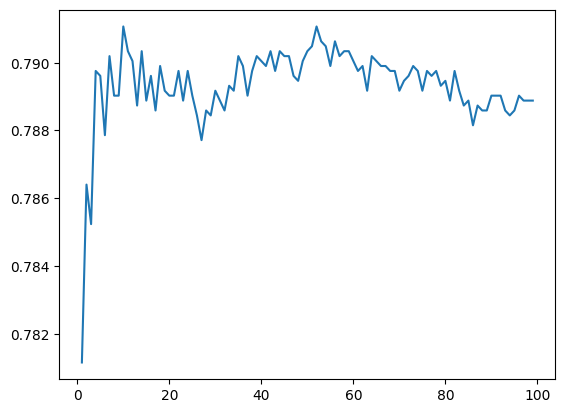

In [50]:
neighbors_list = range(100)
neighbors_list = neighbors_list[1:]
resaccuracy_list = []

for neighbors in neighbors_list:
    knn = KNeighborsClassifier(neighbors)
    knn.fit(train_embeddings, train_labels)

    # Evaluate
    test_preds = knn.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_preds)
    resaccuracy_list.append(accuracy)

# Find the index of the maximum value in y
best_accuracy = max(resaccuracy_list)

# Get the corresponding x value
best_k = neighbors_list[resaccuracy_list.index(max(resaccuracy_list))]

print(f"The best validation accuracy for resnet + knn is {best_accuracy} using k = {best_k}")

plt.plot(neighbors_list,resaccuracy_list)
plt.show()

In [28]:
from sklearn.svm import SVC
import numpy as np

Fitting SVC with C = 0.0001


Fitting SVC with C = 0.00018873918221350977
Fitting SVC with C = 0.0003562247890262444
Fitting SVC with C = 0.0006723357536499335
Fitting SVC with C = 0.0012689610031679222
Fitting SVC with C = 0.002395026619987486
Fitting SVC with C = 0.004520353656360241
Fitting SVC with C = 0.008531678524172805
Fitting SVC with C = 0.01610262027560939
Fitting SVC with C = 0.03039195382313198
Fitting SVC with C = 0.05736152510448681
Fitting SVC with C = 0.1082636733874054
Fitting SVC with C = 0.20433597178569418
Fitting SVC with C = 0.38566204211634725
Fitting SVC with C = 0.7278953843983146
Fitting SVC with C = 1.3738237958832638
Fitting SVC with C = 2.592943797404667
Fitting SVC with C = 4.893900918477489
Fitting SVC with C = 9.236708571873866
Fitting SVC with C = 17.433288221999874
Fitting SVC with C = 32.90344562312671
Fitting SVC with C = 62.10169418915616
Fitting SVC with C = 117.21022975334793
Fitting SVC with C = 221.22162910704503
Fitting SVC with C = 417.53189365604004
Fitting SVC with C = 

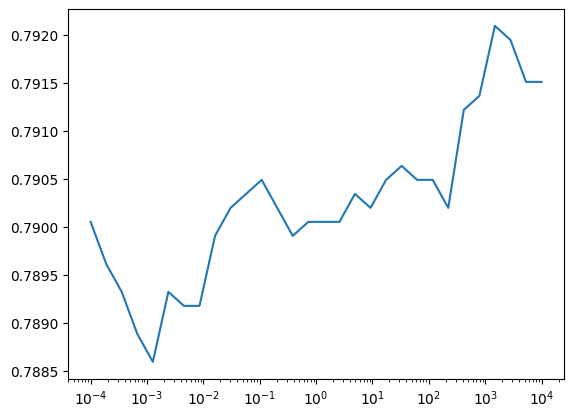

In [40]:
C_list = np.logspace(-4, 4, 30)
resaccuracy_listsvc = []

for C in C_list:
    svc = SVC(C=C)
    print(f"Fitting SVC with C = {C}")
    svc.fit(train_embeddings, train_labels)

    # Evaluate
    test_preds = svc.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_preds)
    resaccuracy_listsvc.append(accuracy)

# Find the index of the maximum value in y
best_accuracy = max(resaccuracy_listsvc)

# Get the corresponding x value
best_c = C_list[resaccuracy_listsvc.index(max(resaccuracy_listsvc))]

print(f"The best validation accuracy for resnet + SVC is {best_accuracy} using C = {best_c}")

plt.plot(C_list,resaccuracy_listsvc)
plt.xscale('log')
plt.show()

### b. EfficientNet Model with KNN

In [51]:
# Extract embeddings and train KNN
embeddingmodel, loss_fn, optimizer = EfficientNet_TML(128)
embeddingmodel.load_state_dict(torch.load("efficientnet_embedder.pt"))

train_embeddings, train_labels = extract_embeddings(classifiertrain_loader, embeddingmodel)
test_embeddings, test_labels = extract_embeddings(classifiertest_loader, embeddingmodel)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The best validation accuracy for efficientnet + knn is 0.8049314269039977 using k = 86


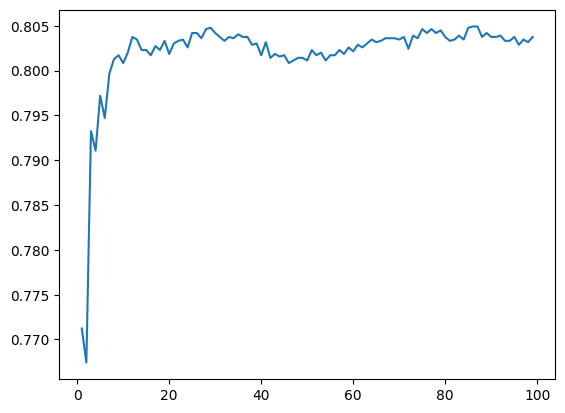

In [52]:
neighbors_list = range(100)
neighbors_list = neighbors_list[1:]
effaccuracy_list = []

for neighbors in neighbors_list:
    knn = KNeighborsClassifier(neighbors)
    knn.fit(train_embeddings, train_labels)

    # Evaluate
    test_preds = knn.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_preds)
    effaccuracy_list.append(accuracy)

# Find the index of the maximum value in y
best_accuracy = max(effaccuracy_list)

# Get the corresponding x value
best_k = neighbors_list[effaccuracy_list.index(max(effaccuracy_list))]

print(f"The best validation accuracy for efficientnet + knn is {best_accuracy} using k = {best_k}")

plt.plot(neighbors_list,effaccuracy_list)
plt.show()

Fitting SVC with C = 0.0001
Fitting SVC with C = 0.00018873918221350977
Fitting SVC with C = 0.0003562247890262444
Fitting SVC with C = 0.0006723357536499335
Fitting SVC with C = 0.0012689610031679222
Fitting SVC with C = 0.002395026619987486
Fitting SVC with C = 0.004520353656360241
Fitting SVC with C = 0.008531678524172805
Fitting SVC with C = 0.01610262027560939
Fitting SVC with C = 0.03039195382313198
Fitting SVC with C = 0.05736152510448681
Fitting SVC with C = 0.1082636733874054
Fitting SVC with C = 0.20433597178569418
Fitting SVC with C = 0.38566204211634725
Fitting SVC with C = 0.7278953843983146
Fitting SVC with C = 1.3738237958832638
Fitting SVC with C = 2.592943797404667
Fitting SVC with C = 4.893900918477489
Fitting SVC with C = 9.236708571873866
Fitting SVC with C = 17.433288221999874
Fitting SVC with C = 32.90344562312671
Fitting SVC with C = 62.10169418915616
Fitting SVC with C = 117.21022975334793
Fitting SVC with C = 221.22162910704503
Fitting SVC with C = 417.53189365

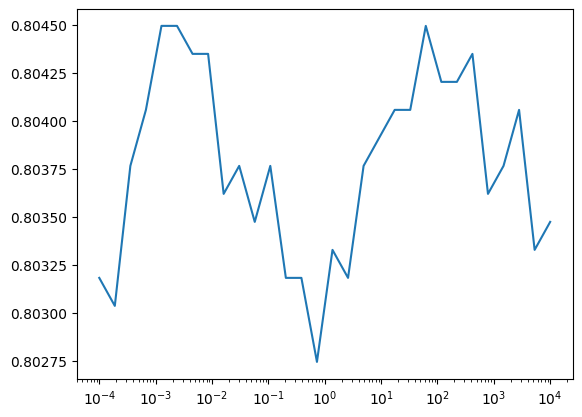

In [42]:
C_list = np.logspace(-4, 4, 30)
effaccuracy_listsvc = []

for C in C_list:
    svc = SVC(C=C)
    print(f"Fitting SVC with C = {C}")
    svc.fit(train_embeddings, train_labels)

    # Evaluate
    test_preds = svc.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_preds)
    effaccuracy_listsvc.append(accuracy)

# Find the index of the maximum value in y
best_accuracy = max(effaccuracy_listsvc)

# Get the corresponding x value
best_c = C_list[effaccuracy_listsvc.index(max(effaccuracy_listsvc))]

print(f"The best validation accuracy for efficientnet + SVC is {best_accuracy} using C = {best_c}")

plt.plot(C_list,effaccuracy_listsvc)
plt.xscale('log')
plt.show()

### c. NasNetLarge Model with KNN

In [53]:
# Extract embeddings and train KNN
embeddingmodel = NasNetLarge_TML(128)
embeddingmodel.load_state_dict(torch.load("nasnet_embedder.pt"))

train_embeddings, train_labels = extract_embeddings(classifiertrain_loader, embeddingmodel)
test_embeddings, test_labels = extract_embeddings(classifiertest_loader, embeddingmodel)


The best validation accuracy for nasnet + knn is 0.7920922089290925 using k = 81


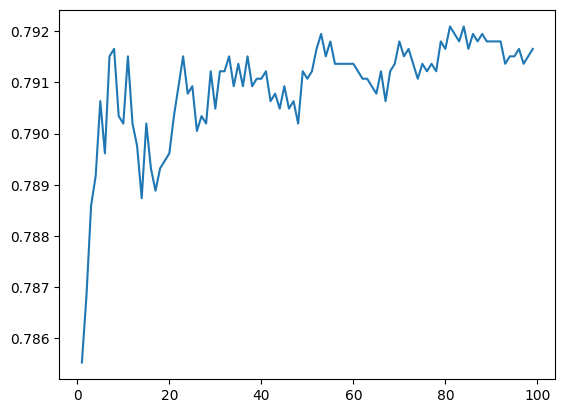

In [54]:
neighbors_list = range(100)
neighbors_list = neighbors_list[1:]
nasaccuracy_list = []

for neighbors in neighbors_list:
    knn = KNeighborsClassifier(neighbors)
    knn.fit(train_embeddings, train_labels)

    # Evaluate
    test_preds = knn.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_preds)
    nasaccuracy_list.append(accuracy)

# Find the index of the maximum value in y
best_accuracy = max(nasaccuracy_list)

# Get the corresponding x value
best_k = neighbors_list[nasaccuracy_list.index(max(nasaccuracy_list))]

print(f"The best validation accuracy for nasnet + knn is {best_accuracy} using k = {best_k}")

plt.plot(neighbors_list,nasaccuracy_list)
plt.show()

Fitting SVC with C = 0.0001
Fitting SVC with C = 0.00018873918221350977
Fitting SVC with C = 0.0003562247890262444
Fitting SVC with C = 0.0006723357536499335
Fitting SVC with C = 0.0012689610031679222
Fitting SVC with C = 0.002395026619987486
Fitting SVC with C = 0.004520353656360241
Fitting SVC with C = 0.008531678524172805
Fitting SVC with C = 0.01610262027560939
Fitting SVC with C = 0.03039195382313198
Fitting SVC with C = 0.05736152510448681
Fitting SVC with C = 0.1082636733874054
Fitting SVC with C = 0.20433597178569418
Fitting SVC with C = 0.38566204211634725
Fitting SVC with C = 0.7278953843983146
Fitting SVC with C = 1.3738237958832638
Fitting SVC with C = 2.592943797404667
Fitting SVC with C = 4.893900918477489
Fitting SVC with C = 9.236708571873866
Fitting SVC with C = 17.433288221999874
Fitting SVC with C = 32.90344562312671
Fitting SVC with C = 62.10169418915616
Fitting SVC with C = 117.21022975334793
Fitting SVC with C = 221.22162910704503
Fitting SVC with C = 417.53189365

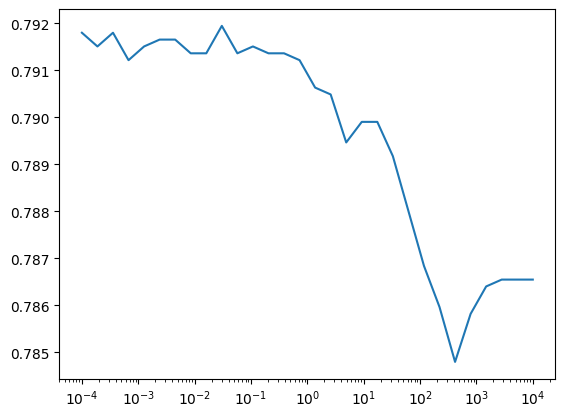

In [44]:
C_list = np.logspace(-4, 4, 30)
nasaccuracy_listsvc = []

for C in C_list:
    svc = SVC(C=C)
    print(f"Fitting SVC with C = {C}")
    svc.fit(train_embeddings, train_labels)

    # Evaluate
    test_preds = svc.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_preds)
    nasaccuracy_listsvc.append(accuracy)

# Find the index of the maximum value in y
best_accuracy = max(nasaccuracy_listsvc)

# Get the corresponding x value
best_c = C_list[nasaccuracy_listsvc.index(max(nasaccuracy_listsvc))]

print(f"The best validation accuracy for efficientnet + SVC is {best_accuracy} using C = {best_c}")

plt.plot(C_list,nasaccuracy_listsvc)
plt.xscale('log')
plt.show()

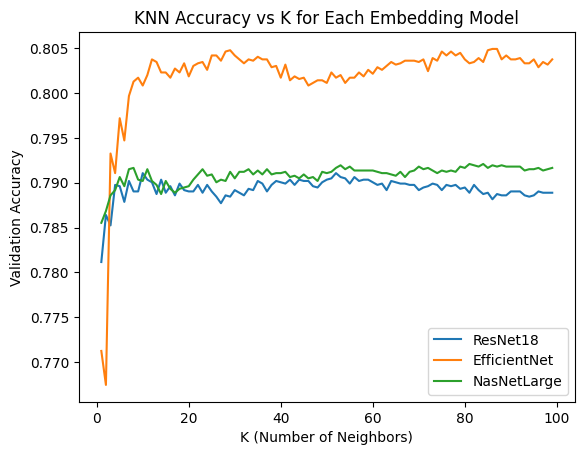

In [55]:
plt.plot(neighbors_list,resaccuracy_list, label="ResNet18")
plt.plot(neighbors_list,effaccuracy_list, label="EfficientNet")
plt.plot(neighbors_list,nasaccuracy_list, label="NasNetLarge")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Validation Accuracy")
plt.title("KNN Accuracy vs K for Each Embedding Model")
plt.legend()
plt.show()


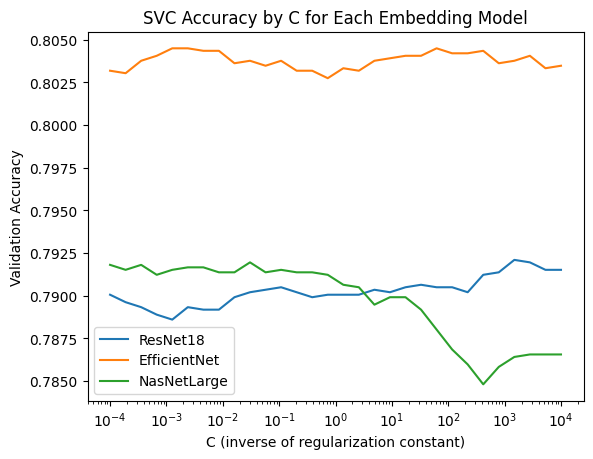

In [48]:
plt.plot(C_list,resaccuracy_listsvc, label="ResNet18")
plt.plot(C_list,effaccuracy_listsvc, label="EfficientNet")
plt.plot(C_list,nasaccuracy_listsvc, label="NasNetLarge")
plt.xlabel("C (inverse of regularization constant)")
plt.xscale("log")
plt.ylabel("Validation Accuracy")
plt.title("SVC Accuracy by C for Each Embedding Model")
plt.legend()
plt.show()


              precision    recall  f1-score   support

     Class 0       0.80      0.79      0.79      3443
     Class 1       0.79      0.80      0.79      3411

    accuracy                           0.79      6854
   macro avg       0.79      0.79      0.79      6854
weighted avg       0.79      0.79      0.79      6854

Average Precision Score: 0.7283775527892795


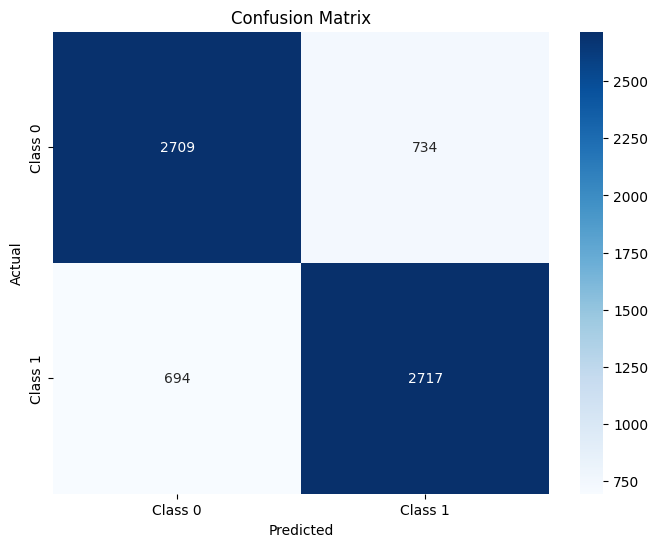

In [17]:

from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Calculate precision, recall, and F1-score
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print(report)
aps = average_precision_score(test_labels, test_preds)
print(f"Average Precision Score: {aps}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 6) Apply SVC classification method

### a. Resnet + SVC